In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def load_snp_csv(snp_file):
    df = pd.read_csv(snp_file)  # do NOT use index_col=0 here
    df.rename(columns={df.columns[0]: 'GID'}, inplace=True)  # First column is GID
    df = df.astype(float, errors='ignore')  # Only SNPs will be float
    return df

class MultiModalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_path, geno_feature_cols, batch_size=32, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_path = image_path
        self.geno_feature_cols = geno_feature_cols
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        
        X_img = []
        X_geno = []
        Y = []
        
        for _, row in batch_df.iterrows():
            # Load image
            img = np.load(os.path.join(self.image_path, row['Filename']))
            X_img.append(img)

            # Genomic features
            geno = row[self.geno_feature_cols].values.astype(np.float32)
            X_geno.append(geno)

            # Yield
            Y.append(row['GRYLD'])

        return [np.array(X_img), np.array(X_geno)], np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [3]:
geno_df = load_snp_csv("SNPs_phased_reduced.csv")

In [4]:
#from sklearn.preprocessing import StandardScaler
#
## Drop GID column for scaling
#geno_features_only = geno_df.drop(columns=['GID'])
#
## Scale
#scaler = StandardScaler()
#geno_scaled = pd.DataFrame(
#    scaler.fit_transform(geno_features_only),
#    index=geno_df.index,
#    columns=geno_features_only.columns
#)
#
## Optionally, add GID back
#geno_scaled['GID'] = geno_df['GID']
#geno_scaled = geno_scaled[['GID'] + list(geno_features_only.columns)]



In [5]:
#geno_df = geno_scaled

In [6]:
#from sklearn.feature_selection import VarianceThreshold
#
#selector = VarianceThreshold(threshold=0.01)
#filtered_array = selector.fit_transform(geno_features_only)
#
## Rebuild dataframe
#filtered_snp_df = pd.DataFrame(filtered_array, index=geno_df.index, columns=geno_features_only.columns[selector.get_support()])

In [7]:
#geno_df = filtered_snp_df

In [4]:
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
img_df = pd.read_csv(csv_path, header=None, names=['Filename', 'GID', 'GRYLD'])

In [5]:
# Load data
#geno_df = pd.read_csv('SNPs_phased_reduced.csv')
#img_df = pd.read_csv('Images_GIDs_GRYLD.csv')

# Reset index to make GID a column again
#geno_df_reset = geno_df.reset_index()

merged_df = pd.merge(img_df, geno_df, on='GID')

# Drop any NaNs
merged_df = merged_df.dropna(subset=['GRYLD'])

# Define genomic columns
geno_feature_cols = [col for col in merged_df.columns if col not in ['GID', 'Filename', 'GRYLD']]

image_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"


from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42)


# Create generator
train_gen = MultiModalDataGenerator(
    dataframe=train_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=True
)

val_gen = MultiModalDataGenerator(
    dataframe=val_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=False  # don't shuffle validation
)

In [6]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

# Load and rename image model
image_model = load_model('CNN.h5', compile=False)
image_model._name = 'image_model'  # Rename to avoid name clash

# Load and rename genotype model
geno_model = load_model('wheat_height_predictor.h5', compile=False)
geno_model._name = 'geno_model'  # Rename to avoid name clash

# Freeze both models
for layer in image_model.layers:
    layer.trainable = False
for layer in geno_model.layers:
    layer.trainable = False

# Define new inputs
img_input = Input(shape=image_model.input_shape[1:], name='image_input')
geno_input = Input(shape=geno_model.input_shape[1:], name='geno_input')

# Pass through models
img_features = image_model(img_input)
geno_features = geno_model(geno_input)

# Combine
fusion = concatenate([img_features, geno_features], name='fusion')
x = Dense(128, activation='relu', name='fusion_dense_1')(fusion)
x = Dropout(0.3, name='fusion_dropout')(x)
output = Dense(1, name='yield_output')(x)

# Final model
fusion_model = Model(inputs=[img_input, geno_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,         
    verbose=1
)

Epoch 1/10
4308/4308 [==============================] - 5838s 1s/step - loss: 1.0450 - mae: 0.7263 - val_loss: 0.0909 - val_mae: 0.2169
Epoch 2/10
4308/4308 [==============================] - 5869s 1s/step - loss: 0.4716 - mae: 0.5419 - val_loss: 0.0994 - val_mae: 0.2293
Epoch 3/10
4308/4308 [==============================] - 5893s 1s/step - loss: 0.3330 - mae: 0.4515 - val_loss: 0.0955 - val_mae: 0.2224
Epoch 4/10
4308/4308 [==============================] - 5869s 1s/step - loss: 0.2353 - mae: 0.3748 - val_loss: 0.0941 - val_mae: 0.2212
Epoch 5/10
4308/4308 [==============================] - 5642s 1s/step - loss: 0.1787 - mae: 0.3211 - val_loss: 0.0946 - val_mae: 0.2196
Epoch 6/10
4308/4308 [==============================] - 5947s 1s/step - loss: 0.1460 - mae: 0.2858 - val_loss: 0.0897 - val_mae: 0.2132
Epoch 7/10
4308/4308 [==============================] - 6100s 1s/step - loss: 0.1276 - mae: 0.2636 - val_loss: 0.0841 - val_mae: 0.2052
Epoch 8/10
4308/4308 [==========================

In [21]:
from sklearn.metrics import r2_score

y_pred_train = fusion_model.predict(train_gen)

y_true_train = np.concatenate([y for _, y in train_gen])

r2_train = r2_score(y_true_train, y_pred_train)
print(f"R² score: {r2:.4f}")

4308/4308 [==============================] - 4557s 1s/step
R² score: 0.8181


In [17]:
from sklearn.metrics import r2_score

y_pred_val = fusion_model.predict(val_gen)
y_true_val = np.concatenate([y for _, y in val_gen])

r2_val = r2_score(y_true_val, y_pred_val)
print(f"Validation R²: {r2_val:.4f}")

1077/1077 [==============================] - 1163s 1s/step
Validation R²: 0.8184


In [10]:
fusion_model.save('Multimodal.h5')

In [9]:
print("Predicted range:", y_pred.min(), "to", y_pred.max())
print("True range:", y_true.min(), "to", y_true.max())

NameError: name 'y_pred' is not defined

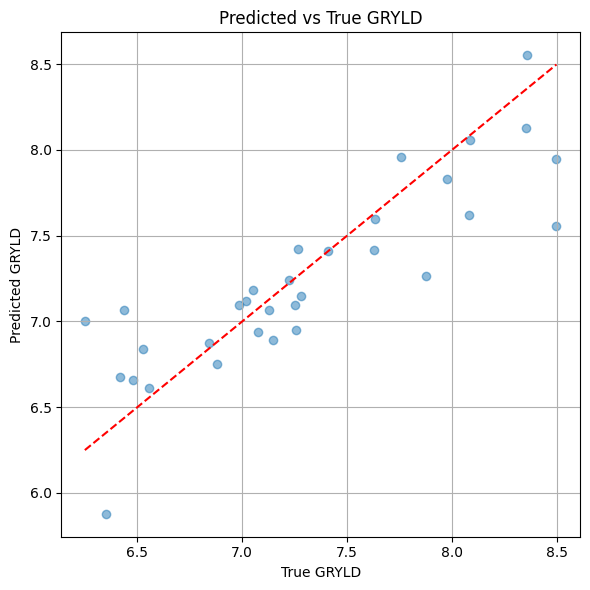

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title('Predicted vs True GRYLD')
plt.grid(True)
plt.tight_layout()
plt.show()

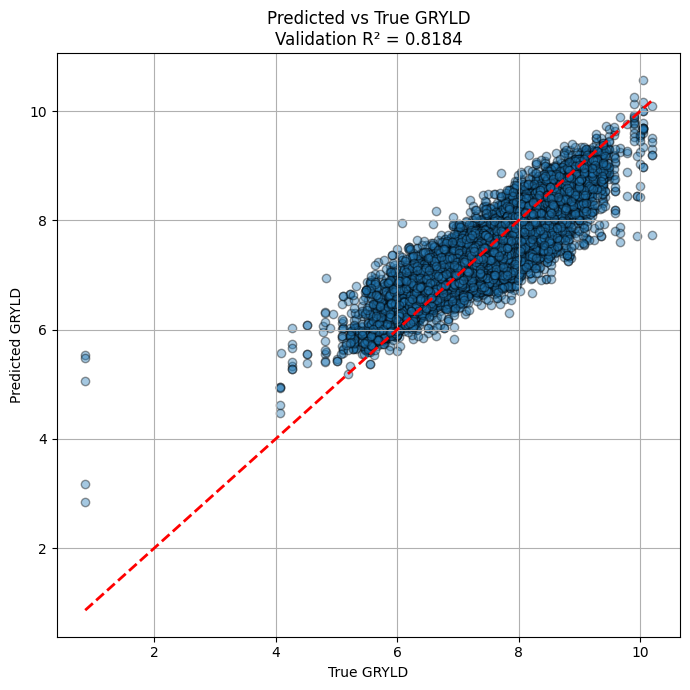

In [20]:
plt.figure(figsize=(7,7))
plt.scatter(y_true_val, y_pred_val, alpha=0.4, edgecolors='k')
plt.plot([y_true_val.min(), y_true_val.max()],
         [y_true_val.min(), y_true_val.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nValidation R² = {r2_val:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

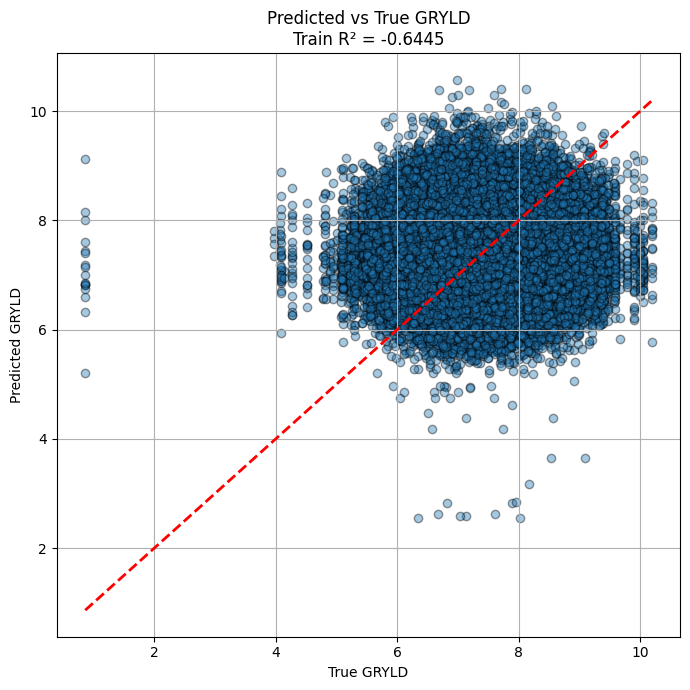

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(y_true_train, y_pred_train, alpha=0.4, edgecolors='k')
plt.plot([y_true_train.min(), y_true_train.max()],
         [y_true_train.min(), y_true_train.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nTrain R² = {r2_train:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Predict on only the first N batches
N = 1000  # test with 3 batches first (or however many fit in memory/time)
y_true_all = []
y_pred_all = []

for i in range(N):
    (X_img, X_geno), y_true = train_gen[i]
    y_pred = fusion_model.predict([X_img, X_geno], verbose=0)
    y_true_all.append(y_true)
    y_pred_all.append(y_pred.flatten())

# Flatten and compute R²
from sklearn.metrics import r2_score
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
print(f"Quick R²: {r2:.4f} (on {len(y_true_all)} samples)")

Quick R²: 0.8181 (on 32000 samples)


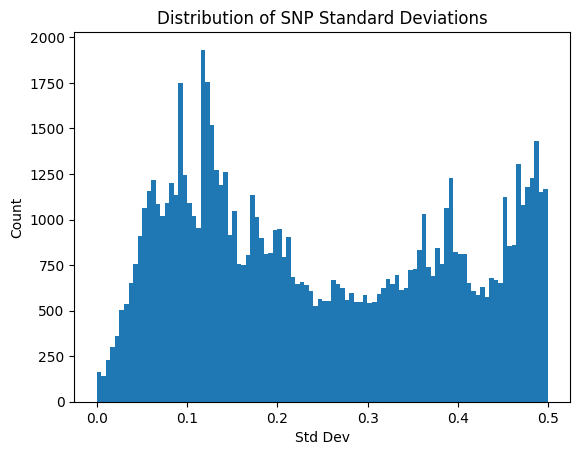

In [11]:
import matplotlib.pyplot as plt
geno_std = merged_df[geno_feature_cols].std(axis=0)
plt.hist(geno_std, bins=100)
plt.title("Distribution of SNP Standard Deviations")
plt.xlabel("Std Dev")
plt.ylabel("Count")
plt.show()

In [7]:
fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    steps_per_epoch=500,
    validation_steps=200, 
    verbose=1
)

Epoch 1/30
500/500 [==============================] - 733s 1s/step - loss: 4.1400 - mae: 1.3186 - val_loss: 0.1350 - val_mae: 0.2782
Epoch 2/30
500/500 [==============================] - 726s 1s/step - loss: 0.9422 - mae: 0.7723 - val_loss: 0.1157 - val_mae: 0.2511
Epoch 3/30
500/500 [==============================] - 752s 2s/step - loss: 0.7855 - mae: 0.7044 - val_loss: 0.0998 - val_mae: 0.2298
Epoch 4/30
500/500 [==============================] - 727s 1s/step - loss: 0.7114 - mae: 0.6669 - val_loss: 0.1040 - val_mae: 0.2379
Epoch 5/30
500/500 [==============================] - 718s 1s/step - loss: 0.6727 - mae: 0.6500 - val_loss: 0.0915 - val_mae: 0.2207
Epoch 6/30
500/500 [==============================] - 768s 2s/step - loss: 0.6237 - mae: 0.6267 - val_loss: 0.0898 - val_mae: 0.2213
Epoch 7/30
500/500 [==============================] - 747s 1s/step - loss: 0.6115 - mae: 0.6197 - val_loss: 0.0985 - val_mae: 0.2312
Epoch 8/30
500/500 [==============================] - 735s 1s/step - 